## Notebook to do longitudinal analysis of cell fractions over time
- here using PPMI as discovery cohort and PDBP as replication
- features to be considered, probably should do in separate notebooks
    - expression ~ time + (1| subject)
    - cell fractions ~ time + (1| subject), (caveat cell fractions predicted based on PPMI, so PDBP not full replication)
    - eqtl_betas ~ time
    
based on running linear mixed effects models in python examples:
- [Comparing R lmer to Statsmodels MixedLM](https://nbviewer.jupyter.org/urls/umich.box.com/shared/static/6tfc1e0q6jincsv5pgfa.ipynb)
- [Linear Mixed Effects Models](https://www.statsmodels.org/devel/examples/notebooks/generated/mixed_lm_example.html)
- [statsmodel mixedlm from formula](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html)

In [1]:
!date

Mon May  3 14:33:27 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [3]:
# parameters
cohort = 'amppd'
disc_cohort = 'PP'
disc_name = 'ppmi'
rep_cohort = 'PD'
rep_name = 'pdbp'
months = [0, 1, 6 , 12, 18, 24, 36]
visit_names = ['BLM0T1', 'SVM0_5T1', 'SVM6T1', 'SVM12T1', 'SVM18T1', 'SVM24T1', 'SVM36T1']
visits = zip(months, visit_names)
quant_type = 'genes'
min_ppscore = 0.05

# directories
home_dir = '/home/jupyter'
wrk_dir = f'{home_dir}/{cohort}'
expr_dir = f'{wrk_dir}/expression'
info_dir = f'{wrk_dir}/sample_info'

# in files
known_covs_file = f'{info_dir}/{cohort}_rna_sample_info.csv'
umaps_file = f'{info_dir}/{cohort}_rna.umap.covs.csv'
quants_file = f'{expr_dir}/{cohort}.{quant_type}.norm.adj.hdf5'
disc_grs_file = f'{home_dir}/{disc_name}/sample_info/{disc_name}.grs.scaled.csv'
rep_grs_file = f'{home_dir}/{rep_name}/sample_info/{rep_name}.grs.scaled.csv'

#### analysis functions

In [4]:
def mixed_model(formula, df, group_name):
    model = sm.MixedLM.from_formula(formula, df, groups=df[group_name])
    result = model.fit()
    return result

def mm_by_subject_hard_covs(dep_var, indep_var, df):
    this_formula = f'{dep_var} ~ {indep_var} + age_at_baseline + sex + \
DX + education_level_years + GRS + x_umap + y_umap'
    print(this_formula)
    results = mixed_model(this_formula, df, 'wgsid')
    return results

#### load the known sample covariates

In [5]:
known_covs_df = pd.read_csv(known_covs_file, index_col=0)
print(known_covs_df.shape)
# display(known_covs_df.head())

(8356, 37)


In [6]:
umaps_df = pd.read_csv(umaps_file, index_col=0)
print(umaps_df.shape)
# display(umaps_df.head())

(8266, 2)


In [7]:
covs_df = umaps_df.merge(known_covs_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)
# display(covs_df.head())

(8266, 39)


#### add month column based on visit

In [8]:
for month, visit in visits:
    covs_df.loc[covs_df['visit'] == visit, 'month'] = int(month)
    
covs_df['month'] = covs_df['month'].astype('int32')

In [9]:
covs_df.groupby('cohort')['month'].value_counts()

cohort  month
BF      1         207
PD      0        1383
        12        575
        6         551
        18        487
        24        456
PP      0        1511
        12        872
        6         853
        24        830
        36        541
Name: month, dtype: int64

#### load the expression matrix

In [10]:
%%time
expr_df = pd.read_hdf(quants_file, index_col=0)
print(expr_df.shape)
# display(expr_df.head())

(8266, 15482)
CPU times: user 384 ms, sys: 718 ms, total: 1.1 s
Wall time: 1.1 s


In [11]:
# display(expr_df.head())

#### subset the discovery and replication cohorts

In [12]:
disc_cov_df = covs_df.loc[covs_df['cohort'] == disc_cohort]
print(disc_cov_df.shape)
# display(disc_cov_df.head())
disc_cov_df.groupby('cohort')['month'].value_counts()

(4607, 40)


cohort  month
PP      0        1511
        12        872
        6         853
        24        830
        36        541
Name: month, dtype: int64

In [13]:
rep_cov_df = covs_df.loc[covs_df['cohort'] == rep_cohort]
print(rep_cov_df.shape)
# display(rep_cov_df.head())
rep_cov_df.groupby('cohort')['month'].value_counts()

(3452, 40)


cohort  month
PD      0        1383
        12        575
        6         551
        18        487
        24        456
Name: month, dtype: int64

#### load and add GRS

In [14]:
disc_grs_df = pd.read_csv(disc_grs_file)
print(disc_grs_df.shape)
# display(disc_grs_df.head())
rep_grs_df = pd.read_csv(rep_grs_file)
print(rep_grs_df.shape)
# display(rep_grs_df.head())

(1276, 3)
(1383, 3)


In [15]:
disc_cov_df = disc_cov_df.reset_index().merge(disc_grs_df, how='inner', 
                                              left_on='wgsid', right_on='IID').set_index('index')
print(disc_cov_df.shape)
# display(disc_cov_df.head())

(3870, 43)


In [16]:
rep_cov_df = rep_cov_df.reset_index().merge(rep_grs_df, how='inner', 
                                            left_on='wgsid', right_on='IID').set_index('index')
print(rep_cov_df.shape)
# display(rep_cov_df.head())

(3022, 43)


In [17]:
# dep_var = 'predicted_Neutrophils'
# indep_var = 'DX'
# this_formula = f'{dep_var} ~ {indep_var}'
# print(this_formula)
# model = sm.MixedLM.from_formula(this_formula, disc_cov_df, 
#                                 groups=disc_cov_df['wgsid'])
# result = model.fit()
# print(result.summary())

In [18]:
# dep_var = 'predicted_Neutrophils'
# indep_var = 'month'
# this_formula = f'{dep_var} ~ {indep_var}'
# print(this_formula)
# model = sm.MixedLM.from_formula(this_formula, disc_cov_df, 
#                                 groups=disc_cov_df['wgsid'])
# result = model.fit()
# print(result.summary())

In [19]:
# endog = disc_cov_df['predicted_Neutrophils']
# disc_cov_df['Intercept'] = 1
# exog = disc_cov_df[['Intercept', 'month']]
# model = sm.MixedLM(endog, exog, groups=disc_cov_df['wgsid'], 
#                                 exog_re=exog['Intercept'])
# result = model.fit()
# print(result.summary())

#### run just the mixed effects model

In [20]:
%%time
cell_cols = disc_cov_df.columns[disc_cov_df.columns.str.startswith('predicted_')].to_list()
# dep_var = 'predicted_Neutrophils'
indep_var = 'month'
# run cell fracs ~ month for all cell types in both discovery and replication cohorts
for cell_type in cell_cols:
    this_formula = f'{cell_type} ~ {indep_var}'
    grouping = 'wgsid'
    result = mixed_model(this_formula, disc_cov_df, grouping)
    print(result.summary())
    result = mixed_model(this_formula, rep_cov_df, grouping)
    print(result.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: predicted_Basophils
No. Observations: 3870    Method:             REML               
No. Groups:       1241    Scale:              0.0064             
Min. group size:  1       Log-Likelihood:     3367.2225          
Max. group size:  5       Converged:          Yes                
Mean group size:  3.1                                            
-------------------------------------------------------------------
               Coef.   Std.Err.      z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept      0.652      0.003   210.834   0.000    0.646    0.658
month          0.000      0.000     0.059   0.953   -0.000    0.000
Group Var      0.007      0.006                                    



/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: predicted_Basophils
No. Observations: 3022    Method:             REML               
No. Groups:       1213    Scale:              0.0047             
Min. group size:  1       Log-Likelihood:     3090.1736          
Max. group size:  5       Converged:          Yes                
Mean group size:  2.5                                            
-------------------------------------------------------------------
              Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept      0.619      0.003   227.649   0.000    0.614    0.624
month         -0.000      0.000    -0.131   0.896   -0.000    0.000
Group Var      0.005      0.006                                    

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: predicted_Eosinophils
No. Observations: 3870

#### run mixed effects model including age, sex, afftected status, GRS, and education level

In [21]:
%%time
cell_cols = disc_cov_df.columns[disc_cov_df.columns.str.startswith('predicted_')].to_list()
# dep_var = 'predicted_Neutrophils'
indep_var = 'month'
# run cell fracs ~ month for all cell types in both discovery and replication cohorts
for cell_type in cell_cols:
    result = mm_by_subject_hard_covs(cell_type, indep_var, disc_cov_df)
    print(result.summary())
    result = mm_by_subject_hard_covs(cell_type, indep_var, rep_cov_df)
    print(result.summary())

predicted_Basophils ~ month + age_at_baseline + sex + DX + education_level_years + GRS + x_umap + y_umap


/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                          Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         predicted_Basophils
No. Observations:         3870            Method:                     REML               
No. Groups:               1241            Scale:                      0.0059             
Min. group size:          1               Log-Likelihood:             3467.3492          
Max. group size:          5               Converged:                  Yes                
Mean group size:          3.1                                                            
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       0.634    0.068  9.275 0.000  0.500  0.769
sex[T.Male]                         

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                          Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         predicted_Basophils
No. Observations:          3022            Method:                     REML               
No. Groups:                1213            Scale:                      0.0045             
Min. group size:           1               Log-Likelihood:             3138.8291          
Max. group size:           5               Converged:                  Yes                
Mean group size:           2.5                                                            
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                       0.701    0.018  38.599 0.000  0.666  0.737
sex[T.Male]               

In [22]:
%%time
cell_cols = disc_cov_df.columns[disc_cov_df.columns.str.startswith('predicted_')].to_list()
# dep_var = 'predicted_Neutrophils'
indep_var = 'month'
# run cell fracs ~ month for all cell types in both discovery and replication cohorts
for cell_type in cell_cols:
    this_formula = f'{cell_type} ~ {indep_var}'
    grouping = 'DX'
    result = mixed_model(this_formula, disc_cov_df, grouping)
    print(result.summary())
    result = mixed_model(this_formula, rep_cov_df, grouping)
    print(result.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: predicted_Basophils
No. Observations: 3870    Method:             REML               
No. Groups:       7       Scale:              0.0137             
Min. group size:  125     Log-Likelihood:     2785.8408          
Max. group size:  1573    Converged:          Yes                
Mean group size:  552.9                                          
-------------------------------------------------------------------
               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept       0.654      0.008   82.969   0.000    0.638    0.669
month          -0.000      0.000   -0.103   0.918   -0.000    0.000
Group Var       0.000      0.002                                   

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: predicted_Basophils
No. Observations: 3022   

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: predicted_Eosinophils
No. Observations: 3870    Method:             REML                 
No. Groups:       7       Scale:              1.6361               
Min. group size:  125     Log-Likelihood:     -6457.2167           
Max. group size:  1573    Converged:          Yes                  
Mean group size:  552.9                                            
----------------------------------------------------------------------
              Coef.    Std.Err.      z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------
Intercept     2.349       0.070    33.772    0.000     2.213     2.486
month         0.001       0.002     0.289    0.773    -0.003     0.004
Group Var     0.027       0.015                                       

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: predicted_Eos

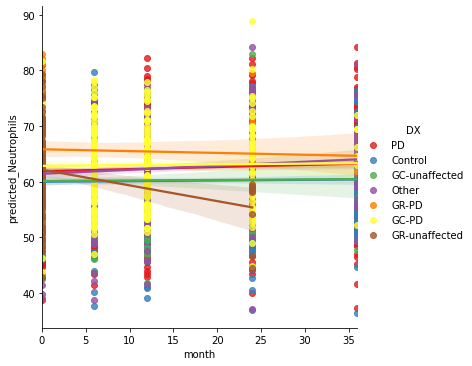

In [23]:
sns.lmplot(x='month', y='predicted_Neutrophils', hue='DX', 
           data=disc_cov_df, palette='Set1')

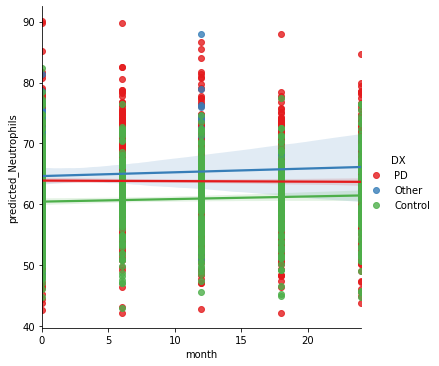

In [24]:
sns.lmplot(x='month', y='predicted_Neutrophils', hue='DX', 
           data=rep_cov_df, palette='Set1')

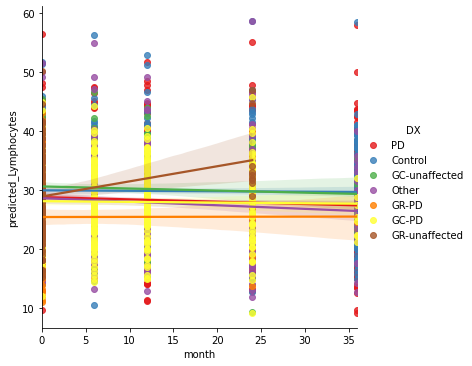

In [25]:
sns.lmplot(x='month', y='predicted_Lymphocytes', hue='DX', 
           data=disc_cov_df, palette='Set1')

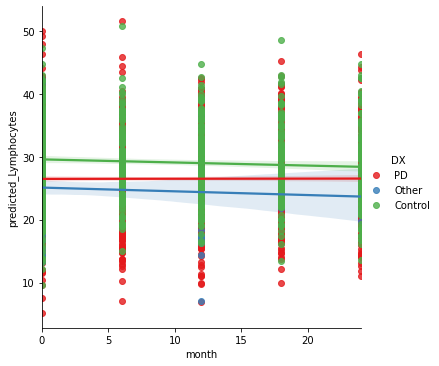

In [26]:
sns.lmplot(x='month', y='predicted_Lymphocytes', hue='DX', 
           data=rep_cov_df, palette='Set1')

In [27]:
result.pvalues

Intercept    0.000000
month        0.586069
Group Var    0.334280
dtype: float64

In [28]:
disc_cov_df['DX'].value_counts()

PD               1573
Control           799
Other             443
GC-PD             426
GC-unaffected     368
GR-unaffected     136
GR-PD             125
Name: DX, dtype: int64

In [29]:
rep_cov_df['DX'].value_counts()

PD         1994
Control     888
Other       140
Name: DX, dtype: int64

In [30]:
disc_cov_df[['predicted_Neutrophils', 'predicted_Lymphocytes', 'x_umap', 'y_umap']].corr()

,predicted_Neutrophils,predicted_Lymphocytes,x_umap,y_umap
predicted_Neutrophils,1.000000,-0.958397,-0.147249,0.180252
predicted_Lymphocytes,-0.958397,1.000000,0.169287,-0.179271
x_umap,-0.147249,0.169287,1.000000,0.487340
y_umap,0.180252,-0.179271,0.487340,1.000000


In [31]:
0.180252**2s

SyntaxError: invalid syntax (<ipython-input-31-186fb8bc2c7b>, line 1)